### Script zur Lehrprobe "Technische und Organisatorische Maßnahmen zur Bias Vermeidung in KI-Systemen für die klinische Entscheidungsfindung"
Berufungsverfahren für Professur in "Human Centered AI and Clinical Decision Support Systems" an der Hochschule Heilbronn  
Autor: Stefan Ehrlich <stefan.kh.ehrlich@gmail.com>  
Datum: 25.07.2025

Quelle: Adult-Income Datenset  
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

#### Übersicht
1. Daten einlesen
2. Daten visualisieren
3. Basismodell trainieren
4. Fairlearn Bias Metriken berechnen
5. Fairness-Contrained Training mittels Exponential Gradient Algorithm
6. Fairlearn Bias Metriken erneut berechnen

Weitere Aufgaben

In [1]:
#################### 1. Daten einlesen ##############################

import pandas as pd

# Datei einlesen
df = pd.read_csv("adult_income_dataset.csv", header=None, na_values=" ?", skipinitialspace=True)

# Spaltennamen ergänzen laut Doku
df.columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Nur relevante Spalten
df = df[["age", "education-num", "race", "hours-per-week", "sex", "income"]].dropna()

# One-Hot-Encoding der race-Spalte
race_encoded = pd.get_dummies(df["race"], prefix="race")

# Kodierung
df["income"] = df["income"].map({">50K": 1, "<=50K": 0})
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})

# Reduziere Merkmale
X = pd.concat([df[["age", "education-num", "hours-per-week"]], race_encoded], axis=1)
y = df["income"]
sensitive_feature = df["sex"]

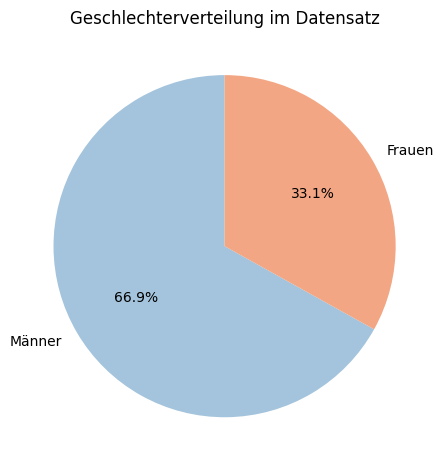

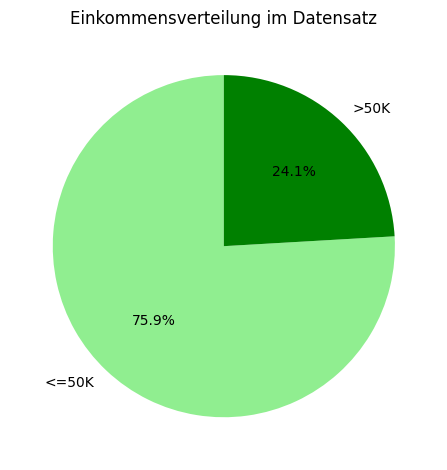

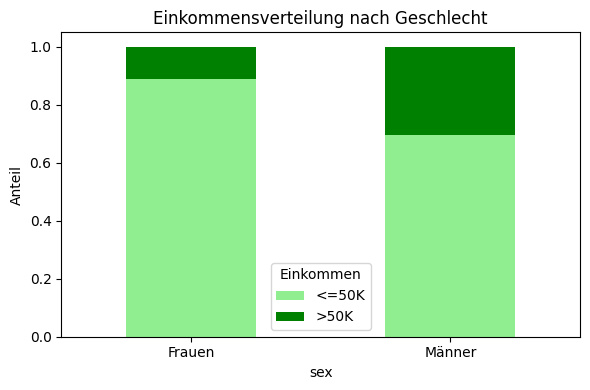

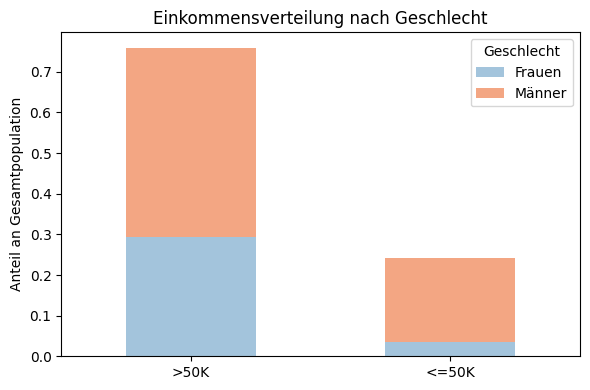

In [2]:
#################### 2. Daten visualisieren ##############################

import matplotlib.pyplot as plt
import pandas as pd

# Annahme: df enthält Spalten "sex" (0=Female, 1=Male), "income" (0=<=50K, 1=>50K)

# 1. Kombinierte Gruppierung
df_grouped = df.groupby(["income", "sex"]).size().unstack(fill_value=0)

# 2. Anteil an der Gesamtmenge berechnen
df_grouped_prop = df_grouped / df_grouped.values.sum()

# 3. Balkendiagramm (gestapelt)
df_grouped_prop.columns = ["Frauen", "Männer"]
df_grouped_prop.index = [">50K", "<=50K"]

# Plotte Geschlechterverteilung im Datensatz
df["sex"].map({0: "Frauen", 1: "Männer"}).value_counts().plot(
    kind="pie", autopct="%.1f%%", startangle=90, 
    colors=["#a3c4dc", "#f3a683"], ylabel=""
)
plt.title("Geschlechterverteilung im Datensatz")
plt.tight_layout()
plt.show()

# Plotte Einkommensverteilung im Datensatz
df["income"].map({0: "<=50K", 1: ">50K"}).value_counts().plot(
    kind="pie", autopct="%.1f%%", startangle=90, 
    colors=["lightgreen", "green"], ylabel=""
)
plt.title("Einkommensverteilung im Datensatz")
plt.tight_layout()
plt.show()

# Plotte Einkommensverteilung nach Geschlecht
pd.crosstab(df["sex"], df["income"], normalize="index").plot(
    kind="bar", stacked=True, color=["lightgreen", "green"], figsize=(6, 4))
plt.xticks([0, 1], ["Frauen", "Männer"], rotation=0)
plt.ylabel("Anteil")
plt.title("Einkommensverteilung nach Geschlecht")
plt.legend(title="Einkommen", labels=["<=50K", ">50K"])
plt.tight_layout()
plt.show()

# Plotte Einkommensverteilung nach Geschlecht (Gesamtpopulation)
df_grouped_prop.plot(
    kind="bar",
    stacked=True,
    color=["#a3c4dc", "#f3a683"],
    figsize=(6, 4)
)
plt.ylabel("Anteil an Gesamtpopulation")
plt.title("Einkommensverteilung nach Geschlecht")
plt.xticks(rotation=0)
plt.legend(title="Geschlecht")
plt.tight_layout()
plt.show()


In [3]:
#################### 3. Basismodell trainieren ##############################

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd

# Daten aufteilen
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42, stratify=y
)

# Skalierung (optional, aber empfohlen)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basismodell: Logistische Regression (biased)
#model = LogisticRegression(solver="liblinear")

# Basismodell: Logistische Regression (unbiased)
model = LogisticRegression(solver="liblinear", class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Vorhersagen
predictions_baseline = model.predict(X_test_scaled)

# 1. Grundgenauigkeit ausgeben
baseline_accuracy = accuracy_score(y_test, predictions_baseline)
print(f"Baseline-Accuracy: {baseline_accuracy:.3f}")

# 2. Confusion Matrix
# Labels explizit angeben, um Klarheit zu schaffen
tn, fp, fn, tp = confusion_matrix(y_test, predictions_baseline, labels=[0, 1]).ravel()

# 3. Metriken berechnen
tpr = tp / (tp + fn)  # Sensitivity / Recall
tnr = tn / (tn + fp)  # Specificity

print(f"True Positive Rate (Recall):      {tpr:.3f}")
print(f"True Negative Rate (Specificity): {tnr:.3f}")

# Für spätere Fairnessanalyse merken:
y_true = y_test
sensitive_test = s_test

#### Ergebnis
# Baseline accuracy etwa 72%, balancierte TPR und TNR aufgrund gewichteter Klassen beim Training des Basismodels

Baseline-Accuracy: 0.723
True Positive Rate (Recall):      0.731
True Negative Rate (Specificity): 0.720


In [4]:
#################### 4. Fairlearn Bias Metriken berechnen ##############################

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

# Gruppenbasierte Metriken berechnen
mf = MetricFrame(
    metrics={
        "Accuracy": accuracy_score,
        "Selection Rate": selection_rate,
        "TPR": true_positive_rate,
        "FPR": false_positive_rate
    },
    y_true=y_true,
    y_pred=predictions_baseline,
    sensitive_features=sensitive_test
)

# Übersicht nach Gruppen
print("📊 Fairness-Metriken nach Geschlecht:")
print(mf.by_group)

# Demographic Parity Difference (gesamt)
dpd = demographic_parity_difference(y_true, predictions_baseline, sensitive_features=sensitive_test)
eod = equalized_odds_difference(y_true, predictions_baseline, sensitive_features=sensitive_test)

print(f"\nDemographic Parity Difference: {dpd:.3f}")
print(f"Equalized Odds Difference:     {eod:.3f}")

#### Ergebnis
# Frauen (sex = 0) erhalten deutlich seltener eine positive Vorhersage („>50K Einkommen“): nur 29.4 % vs. 43.3 % bei Männern
# Die True Positive Rate (TPR) ist bei Frauen niedriger → sie werden seltener richtig positiv klassifiziert, obwohl sie >50K verdienen
# Die Accuracy ist bei Frauen höher, was aber oft kein gutes Zeichen ist, da das Modell hier meist einfach „<=50K“ vorhersagt und damit selten „danebenliegt“

📊 Fairness-Metriken nach Geschlecht:
     Accuracy  Selection Rate       TPR       FPR
sex                                              
0    0.734917        0.291966  0.620112  0.250616
1    0.717047        0.435464  0.751254  0.297858

Demographic Parity Difference: 0.143
Equalized Odds Difference:     0.131


In [5]:
#################### 5. Fairness-Contrained Training mittels Exponential Gradient Algorithm  ##############################
# ExponentedGradient: Fairness-bewusste Optimierung durch gewichtete Modellmischung anhand des definierten Fairness Kriteriums

from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression

# Fairness-Constrained Learning
base_estimator = LogisticRegression(solver="liblinear",class_weight="balanced")
mitigator = ExponentiatedGradient(
    estimator=base_estimator,
    constraints=DemographicParity(),
    eps=0.01  # Strenge der Fairness-Bedingung (wieviel fairness Verletzung akzeptiert wird)
)

# Fit mit separatem sensitive_feature
mitigator.fit(X_train_scaled, y_train, sensitive_features=s_train)

# Vorhersagen
y_pred_eg = mitigator.predict(X_test_scaled)

# Grundgenauigkeit ausgeben
baseline_accuracy = accuracy_score(y_test, y_pred_eg)
print(f"Baseline-Accuracy: {baseline_accuracy:.3f}")

# 2. Confusion Matrix
# Labels explizit angeben, um Klarheit zu schaffen
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_eg, labels=[0, 1]).ravel()

# 3. Metriken berechnen
tpr = tp / (tp + fn)  # Sensitivity / Recall
tnr = tn / (tn + fp)  # Specificity

print(f"True Positive Rate (Recall):      {tpr:.3f}")
print(f"True Negative Rate (Specificity): {tnr:.3f}")

#### Ergebnis
# Baseline accuracy etwa 66.8%, balancierte TPR und TNR, etwas schlechter als initiales Basismodell

Baseline-Accuracy: 0.617
True Positive Rate (Recall):      0.667
True Negative Rate (Specificity): 0.602


In [6]:
#################### 6. Fairlearn Bias Metriken erneut berechnen ##############################

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

# Gruppenbasierte Metriken berechnen
mf = MetricFrame(
    metrics={
        "Accuracy": accuracy_score,
        "Selection Rate": selection_rate,
        "TPR": true_positive_rate,
        "FPR": false_positive_rate
    },
    y_true=y_true,
    y_pred=y_pred_eg,
    sensitive_features=sensitive_test
)

# Übersicht nach Gruppen
print("📊 Fairness-Metriken nach Geschlecht:")
print(mf.by_group)

# Demographic Parity Difference (gesamt)
dpd = demographic_parity_difference(y_true, y_pred_eg, sensitive_features=sensitive_test)
eod = equalized_odds_difference(y_true, y_pred_eg, sensitive_features=sensitive_test)

print(f"\nDemographic Parity Difference: {dpd:.3f}")
print(f"Equalized Odds Difference:     {eod:.3f}")

#### Ergebnis
# Frauen (sex = 0) erhalten nun einen ähnlich hohen Wert für die positive Vorhersage („>50K Einkommen“): 45.6 % vs. 46.2 % bei Männern
# Die Werte für Demongraphic Parity Difference und Equalized Odds Difference sinken von etwa 14 % auf unter 5 %

📊 Fairness-Metriken nach Geschlecht:
     Accuracy  Selection Rate       TPR       FPR
sex                                              
0    0.585495        0.452641  0.670391  0.425202
1    0.633029        0.467732  0.665998  0.381337

Demographic Parity Difference: 0.015
Equalized Odds Difference:     0.044


### Aufgaben:

1. Integrieren Sie weitere Variablen, wie z.b. "marital-status" oder "relationship" in das Prädiktionsmodell. Beschreiben Sie in wenigen Sätzen ob und wie dies die Genauigkeit des Basismodells verändert und welche Auswirkungen dies auf das Fairness-Constrained Training hat. 

2. Variieren Sie die Strenge der Fairness-Bedingung "eps". Beschreibe in wenigen Sätzen welche Auswirkungen dies auf die Fairness-Metriken hat.

3. Auch die Variable "race" ist ungleich verteilt und es ist davon auszugehen, dass Minderheiten durch das Modell weniger gut repräsentiert werden.
Passen Sie das Script so an, dass nicht "sex", sondern "race" als sensitive Variable verwendet wird. Lässt sich das Bias im Modell ebensogut wie bei der Variable "sex" reduzieren?

### Bonusaufgabe:

4. Passen Sie das Script so an, dass sowohl "sex" als auch "race" als sensitive Variablen berücksichtigt werden.

![Race Distribution](figures/race_distribution.png)


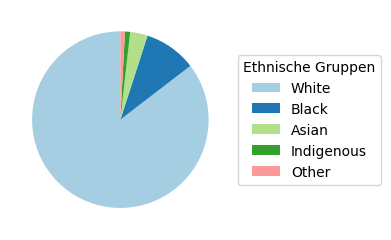

In [11]:
#################### Verteilung der Ethnischen Gruppen ##############################

import matplotlib.pyplot as plt

# Gruppierung (falls noch nicht vorhanden)
race_map = {
    "White": "White",
    "Black": "Black",
    "Asian-Pac-Islander": "Asian",
    "Amer-Indian-Eskimo": "Indigenous",
    "Other": "Other"
}
df["race_grouped"] = df["race"].map(race_map)
race_counts = df["race_grouped"].value_counts()

# Plot ohne direkte Labels, dafür mit Legende
fig, ax = plt.subplots(figsize=(4, 4))
wedges, texts = ax.pie(
    race_counts,
    startangle=90,
    colors=plt.cm.Paired.colors
)

# Legende hinzufügen
ax.legend(wedges, race_counts.index, title="Ethnische Gruppen", loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("race_distribution.png", bbox_inches='tight')
# Titel und Layout
#plt.title("Verteilung der ethnischen Gruppen (race)")
plt.tight_layout()
plt.show()
